# Finding Lane Lines on the Road

This is the project one for term one. The main goal is to be able to **detect/draw road lines** in a set of test provided incoming images and videos(sequential set of images).

I used [anaconda](https://www.anaconda.com/) Python flavour (version 3.6.1) and an open source library python dedicated for image and deep learning called [OpenCV](https://opencv.org/releases.html) (version 3.1.0).

For my solution proposed, the next techniques were applied:
* [Color Transformation](https://physics.info/color/).
* [Canny Edge detection](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjA-PXnnZ7YAhVBUd8KHcCSAIkQFggqMAA&url=http%3A%2F%2Fieeexplore.ieee.org%2Fdocument%2F4767851%2F&usg=AOvVaw0W14eP78FE6nl2CmMnqDtZ).
* [ROI ( Region Of Interest) selection](https://docs.opencv.org/3.3.0/d3/df2/tutorial_py_basic_ops.html)
* [Hough line Transform](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)

This is a non exclusive list of openCV functions I used:
* [cv2.cvtColor()](https://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html) , [cv2.inRange()](https://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html), [cv2.bitwise_or()](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) , [cv2.bitwise_and()](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html). Used for color space transforms.
* [cv2.Canny()](https://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html). Used for gradients computation(edge/borders detection).
* [cv2.GaussianBlur()](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html). Used for image filtering(2d cross correlation).
* [cv2.line()](https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html). Used to draw lines.
* [cv2.HoughLinesP()](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html). Used for Hough-image space transform.
* [cv2.addWeighted()](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html). Used for image blending.



In [1]:
# import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math



The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
# realative paths

# path incoming information
pathInImgs = ('./test_images/')  # path incoming images
pathInVids = ('./test_videos/')  # path incoming videos

# path outgoing information
pathOutImgs = ('./test_images_output/')  # path incoming images
pathOutVids = ('./test_videos_output/')  # path incoming videos


Let's plot the test images:

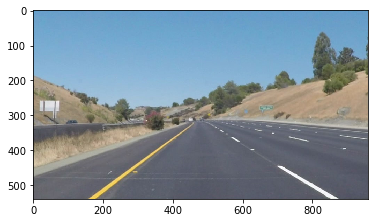

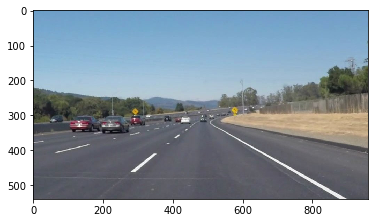

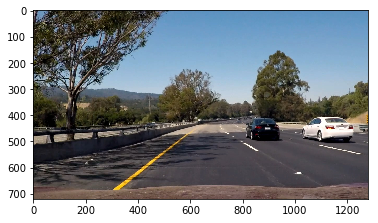

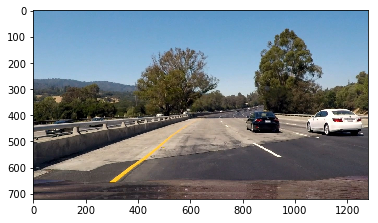

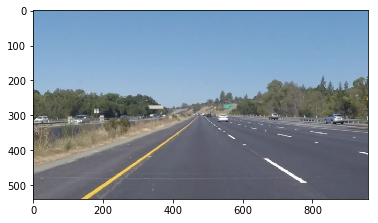

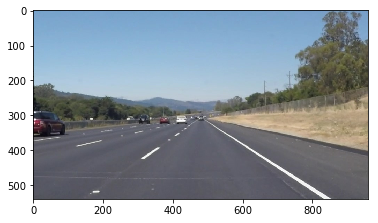

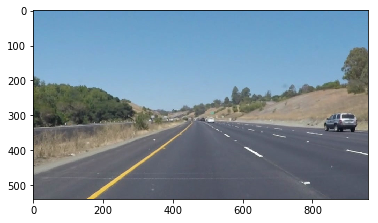

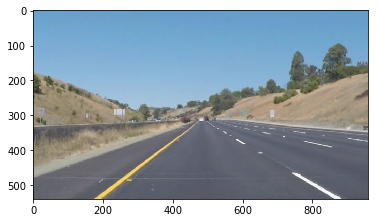

In [5]:
# Plotting test images

namesTestImgs = os.listdir('./test_images/')

# list with all test images
initialTestImgs= []
for i in range(len(namesTestImgs)):
    initialTestImgs.append(mpimg.imread(pathInImgs+namesTestImgs[i]))

# create copy for initial images
testImgs = np.copy(initialTestImgs)


for i in testImgs:
    plt.imshow(i)
    plt.show()
   


## Color Transformation

### RGB color space


Images where loaded in RGB color-space. Inspired on [this document](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) I decided to check what happens if I apply _(Red,Green,Blue,Yellow_ and _White)_ __masks__ in **RGB color-space** and comparing them with _(Yellow,white)_ in **HSL color-space**.

In [6]:
# 1.1 rgb white yellow mask
def rgb_wyMask(img):
    '''
    This functions returns a copy of the input image after aplying white and yellow masks in RGB space.
    
    '''
    minval= 195 # lower threshold 
    alpha= 13/16  # hyperparameter
    imgx = np.copy(img) # working with copies, not the original image.
    
    # Red Mask
    lowerRed= np.array([minval,0,0], dtype=np.uint8)
    upperRed= np.array([255,255,255], dtype=np.uint8)
    redMask= cv2.inRange(imgx, lowerRed, upperRed)
    # Green Mask
    lowerGreen= np.array([0,minval,0], dtype=np.uint8)
    upperGreen= np.array([255,255,255], dtype=np.uint8)
    greenMask= cv2.inRange(imgx, lowerGreen, upperGreen)
    # Blue Mask
    lowerBlue= np.array([0,0,minval], dtype=np.uint8)
    upperBlue= np.array([255,255,255], dtype=np.uint8)
    blueMask= cv2.inRange(imgx, lowerBlue, upperBlue)
    # Yellow Mask
    lowerYellow= np.array([minval*alpha,minval*alpha,0], dtype=np.uint8)
    upperYellow= np.array([255,255,255], dtype=np.uint8)
    yellowMask= cv2.inRange(imgx, lowerYellow, upperYellow)
    # White Mask
    lowerWhite= np.array([minval,minval,minval], dtype=np.uint8)
    upperWhite= np.array([255,255,255], dtype=np.uint8)
    whiteMask= cv2.inRange(imgx, lowerWhite, upperWhite)
    
    # Bitwise-OR
    ywMask1 = cv2.bitwise_or(yellowMask, whiteMask)   
    ywMask2 = cv2.bitwise_or(yellowMask, redMask)   
    ywMask3 = cv2.bitwise_or(yellowMask, greenMask)   
    ywMask4 = cv2.bitwise_or(yellowMask, blueMask)
    ywMask5 = cv2.bitwise_or(ywMask1, ywMask2)   
    
    # Bitwise-AND  (original_image) and (Yellow-White mask)
    ywMaskout = cv2.bitwise_and(imgx, imgx, mask = ywMask1)
    
    return ywMaskout

In [7]:
# 1.2 hls white yellow mask
def hls_wyMask(img):
    '''
    This functions returns a copy of the input image after aplying white and yellow masks in HSL space.
    
    '''
    #image in RGB space
    imgRGB = np.copy(img)
    #image in HSL space
    imgHSL = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HLS)
    # Yellow Mask
    lowerYellow= np.array([ 10, 0, 100], dtype=np.uint8)
    upperYellow= np.array([40,255,255], dtype=np.uint8)
    yellowMask= cv2.inRange(imgHSL, lowerYellow, upperYellow)
    # White Mask
    lowerWhite= np.array([ 0, 200, 0], dtype=np.uint8)
    upperWhite= np.array([255,255,255], dtype=np.uint8)
    whiteMask= cv2.inRange(imgHSL, lowerWhite, upperWhite)
    
    # Yellow or White colors passes
    ywMask1 = cv2.bitwise_or(yellowMask, whiteMask)
    # Bitwise-AND  (hls_image) and (Yellow-White mask)
    ywMaskout = cv2.bitwise_and(imgRGB, imgRGB, mask = ywMask1)

    return ywMaskout

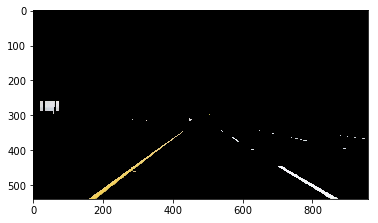

NameError: name 'A' is not defined

In [54]:
# Comparing RGB and HLS color spaces

hlsImgs = []
for i in range(len(testImgs)):
    plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(rgb_wyMask(testImgs[i]))
    #plt.subplot(1, 2, 2)
    plt.imshow(hls_wyMask(np.copy(testImgs[i])))
    hlsImgs.append(hls_wyMask(np.copy(testImgs[i])))
    plt.show()
    
    out_filename= ( './step_by_step_images/hls/'+str(i) )
    plt.imsave(out_filename, , format='png')
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()
    

In HSL color-space _yellow line_ is better defined than in RGB color-space. So I decided to work with _images filtered_ in HSL color-space.

For yellow color:
* Hue > 30
* Ligh = 0 = Not filtered
* Saturation > 90

For white color:
* Hue = 0 = not filtered
* Ligh >= 200
* Saturation = 0 = Not filtered
    

## Canny Edge detection

To find high gradient values to detect borders on images _openCV implementation for canny algorithm_ was used.

### Gray scale Images

Before appying _canny algorithm_ images are mapped to _gray-scale_ representation.

In [9]:
# 2. convert image to gray-scale
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


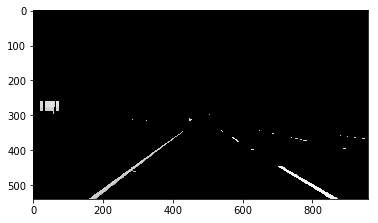

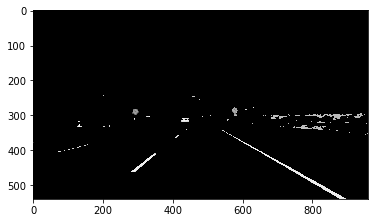

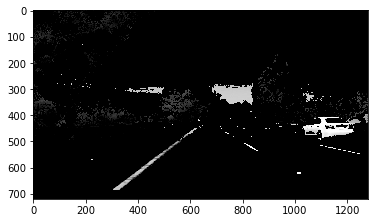

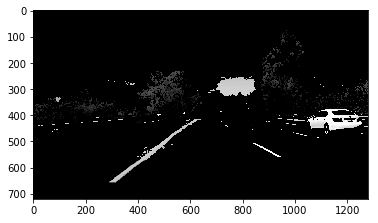

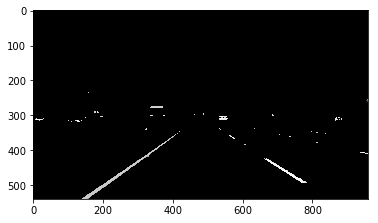

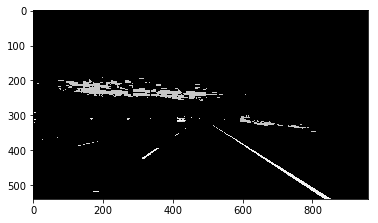

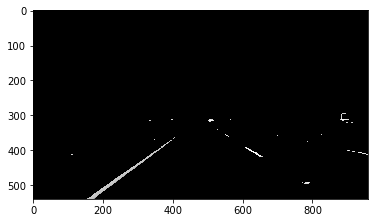

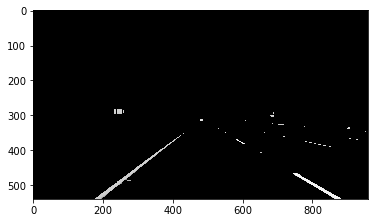

In [10]:
grayImgs= []
# Comparing RGB and HLS color spaces
for i in range(len(testImgs)):
    #plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(hlsImgs[i])
    #plt.subplot(1, 2, 2)
    plt.imshow(grayscale(np.copy(hlsImgs[i])), cmap='gray')
    grayImgs.append( grayscale(np.copy(hlsImgs[i])) )
    plt.show()
    

#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

### Gaussian Blur

To avoid noise edge detection image is smoothed so that gradients (pixel intensity variations) can be detected easier. For that [cv2.GaussianBlur()](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html) was used. I used kernel size = filter size = 15.

In [11]:
# 3. Gaussian blur
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

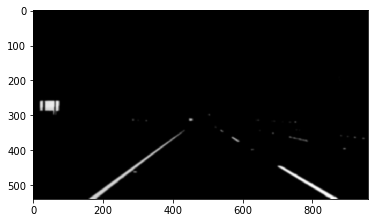

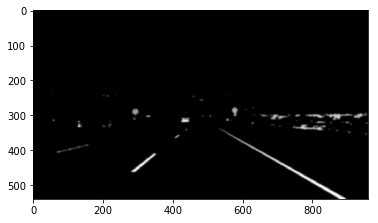

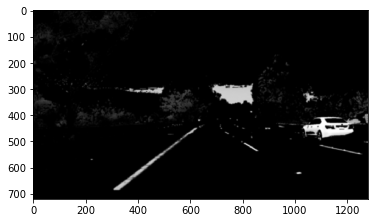

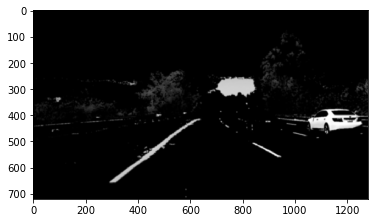

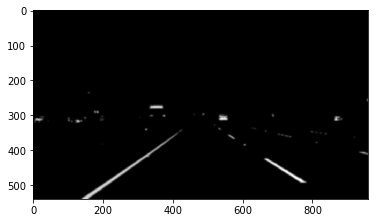

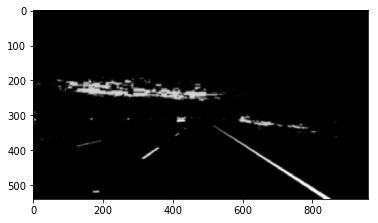

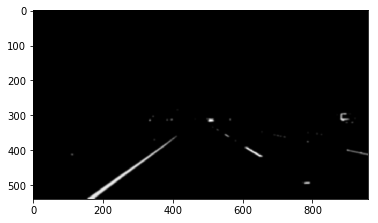

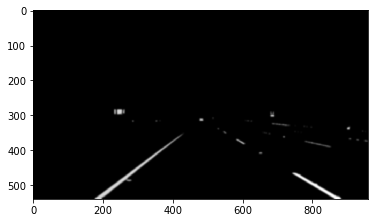

In [12]:
blurImgs= []
# Comparing RGB and HLS color spaces
for i in range(len(testImgs)):
    #plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(blurImgs[i])
    #plt.subplot(1, 2, 2)
    plt.imshow(gaussian_blur(np.copy(grayImgs[i]), 11), cmap='gray')
    blurImgs.append(gaussian_blur(np.copy(grayImgs[i]), 11))
    plt.show()

#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

### Borders detection

Acording to documentation [cv2.Canny()](https://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html), lower and upper threshold for border detection must be adjusted. However, is recommended in [here](https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html) to use a _upper:lower_ ratio between **2:1** and **3:1**.

Following values were selected:
* Upper threshold: 150
* Lower threshold: 50
* _upper:lower_ ratio : 150/50 = 3:1

In [14]:
# 4. Edge detection
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

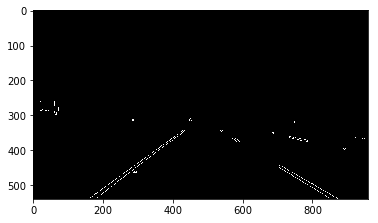

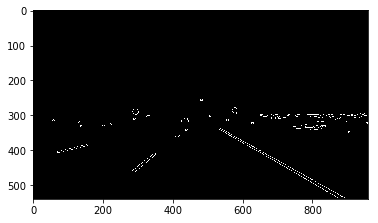

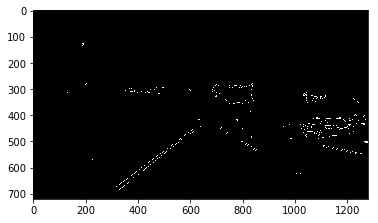

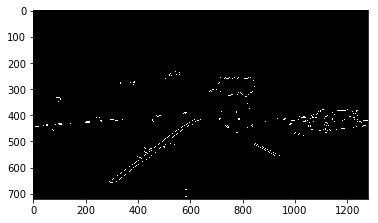

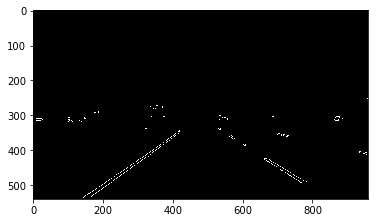

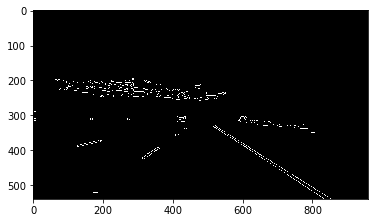

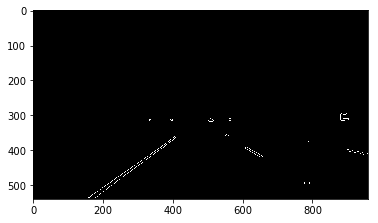

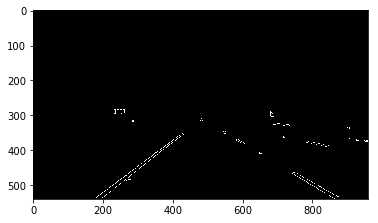

In [15]:
edgeImgs= []
# Finding image gradients
for i in range(len(testImgs)):
    #plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(blurImgs[i])
    #plt.subplot(1, 2, 2)
    plt.imshow(canny(np.copy(blurImgs[i]), 50,150), cmap='gray')
    edgeImgs.append(canny(np.copy(blurImgs[i]), 50,150))
    plt.show()
    
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

#### Morphological Transformations

After aplying canny edge detection. Noticed there are non continuous lines at the edge of _left-right_ road lines regions. So to reduce noise in the averaged _left-line region_ and _rigth-line region_, than is , to close up open regions [dilatation followed by erosion](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#dilation) was applied.

In [16]:
# 4.2 Closing regions
def closing_regions(img, kernel=np.ones((3,3),np.uint8)):
    dilatation = cv2.dilate(img,kernel,iterations = 3)
    erosion = cv2.erode(dilatation,kernel,iterations = 1)
    
    closed = erosion
    return closed

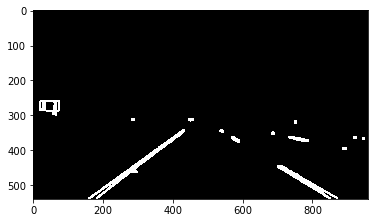

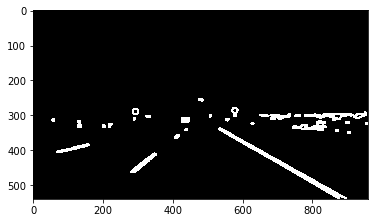

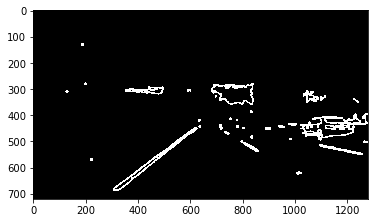

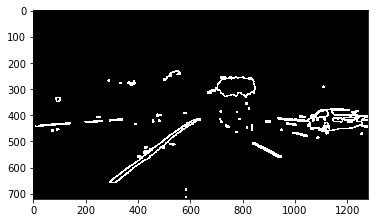

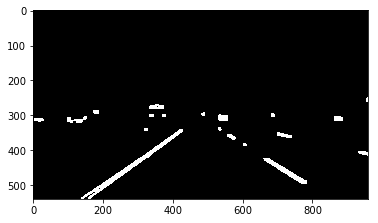

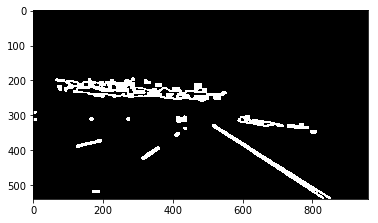

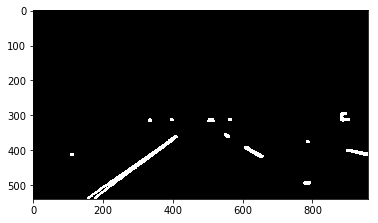

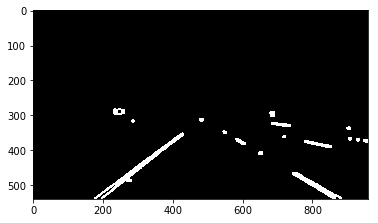

In [17]:
edgeclosedImgs= []
# closing regions
for i in range(len(testImgs)):
    #plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(blurImgs[i])
    #plt.subplot(1, 2, 2)
    plt.imshow(closing_regions(np.copy(edgeImgs[i]),kernel=np.ones((3,3),np.uint8)), cmap='gray')
    edgeclosedImgs.append(closing_regions(np.copy(edgeImgs[i]),kernel=np.ones((3,3),np.uint8)))
    plt.show()
    
    
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

## Region Of Interest (ROI) selection

### Generate image vertices

First off of, to reduce problem complexity, a focus region was introduced.

**Note:** At first attempt morphological transformation was not applied , so, averaged regions became noisy. To Improve that, my first insight was to  try different regions looking for noising out _spurious-contours_ close to the _left-rigth_ lines. I tried different region-shapes. But then I realized **most of power image noise ** is highly present in **non-closed** image regions. So I used the first polygon I initially tried out, a _truncated-triangle = trapezium_.

** Note2:** region vertices position calibration was done by _trial-error_. So, there should be an algorith to recalibrate those points while car is on the road, and the points here presented should be interpreted as _points-localization initialization_.

In [18]:
# 5.1 Generate image vertices
def generate_vertices(img):

    #h,w,d= img.shape  # this line is for width x heigh x depht images
    h,w= img.shape     # this line is for width x heigh images
    out_downLeft = [0.15*w, 0.99*h]
    out_upLeft   = [0.43*w, 0.6*h]
    out_upRigth  = [0.58*w, 0.6*h]
    out_downRigth= [0.98*w, 0.99*h]
    
    in_downRigth=  [0.6*w, 0.96*h]
    in_upRigth  =  [0.52*w, 0.6*h]
    in_upLeft   =  [0.48*w, 0.6*h]
    in_downLeft =  [0.4*w, 0.96*h]
    
    #vertices= np.array([[ out_downLeft, out_upLeft, out_upRigth, out_downRigth, in_downRigth, in_upRigth, in_upLeft, in_downLeft ]], dtype= np.int32)
    vertices= np.array([[ out_downLeft, out_upLeft, out_upRigth, out_downRigth ]], dtype= np.int32)
    return vertices

### Image mask-out

Region of interest selection was applied on preprocesed image by **blacking-out ** positions _out of selected shape_.

In [19]:
# 5.2 Mask image into polygon
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a zeros-mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

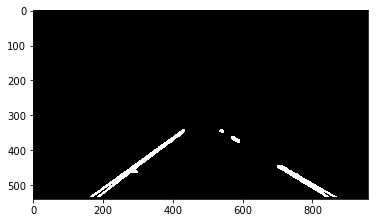

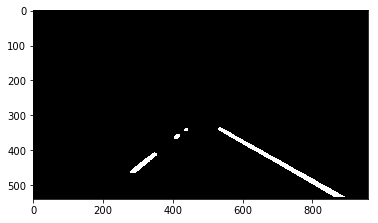

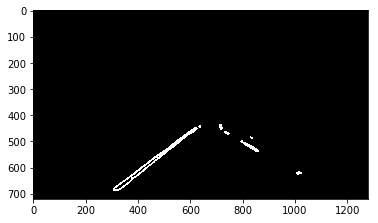

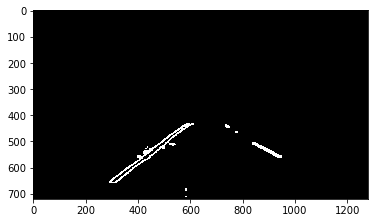

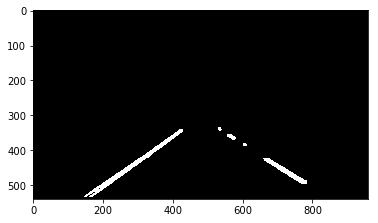

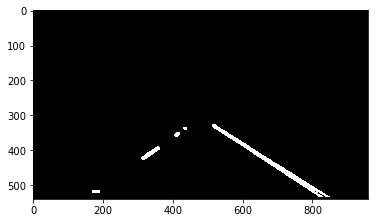

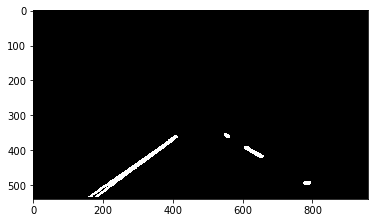

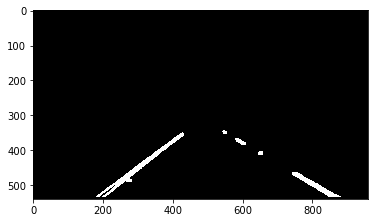

In [25]:
# 5.2 Mask image into polygon
regionImgs= []
for i in range(len(testImgs)):
    #plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(testImgs[i])
    #plt.subplot(1, 2, 2)
    vertices = generate_vertices(np.copy(edgeclosedImgs[i]))
    plt.imshow(region_of_interest(np.copy(edgeclosedImgs[i]),vertices), cmap='gray')
    regionImgs.append(region_of_interest(np.copy(edgeclosedImgs[i]),vertices))
    plt.show()
    
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

## Hough Transform

Once image is preprocessed and the region of interest is selected, **hough transform** is applied to find a set of posible detected lines that afterwards will be narrow down/average out.

In [26]:
# 6.2 draw posible lines (set of lines) along the road lines
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imgx = np.copy(img)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(imgx, (x1, y1), (x2, y2), color, thickness)
    
    return imgx

In [27]:
# 6.1 compute hough transform
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = draw_lines(line_img, lines)
    return line_img, lines

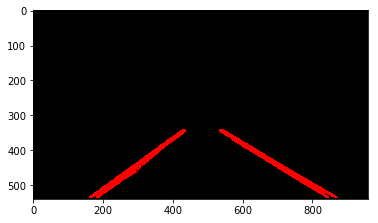

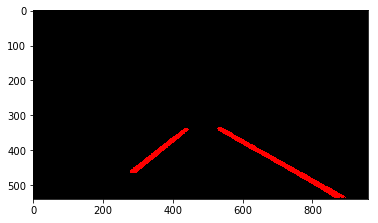

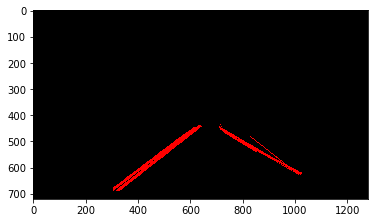

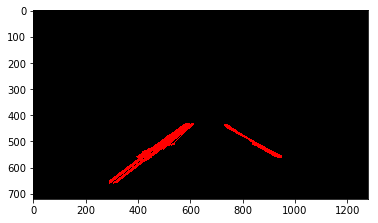

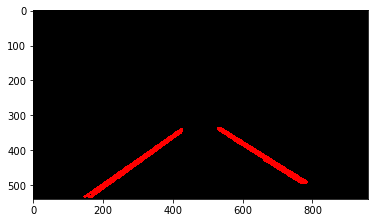

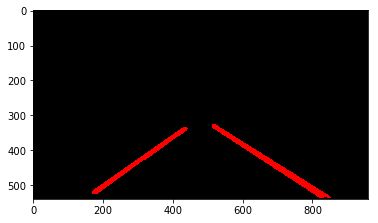

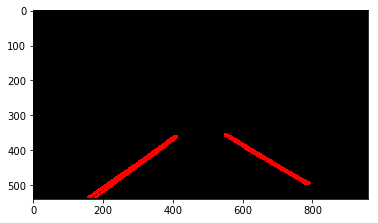

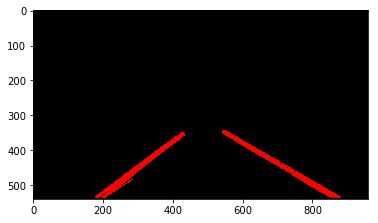

In [28]:
# 6.1 compute hough transform
posslinesImgs= []
possibleLines= []
for i in range(len(testImgs)):
    xpoints,xlines = hough_lines(np.copy(regionImgs[i]), rho=1, theta= 1*np.pi/180, threshold=25, min_line_len= 30, max_line_gap= 200)
    plt.imshow(xpoints)
    posslinesImgs.append(xpoints)
    possibleLines.append(xlines)
    plt.show()
    
    
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

So, the _set of possible lines_ on the road looks as follows:

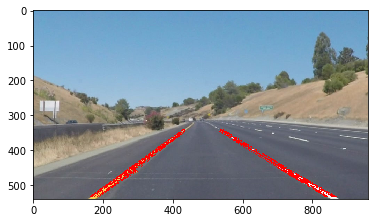

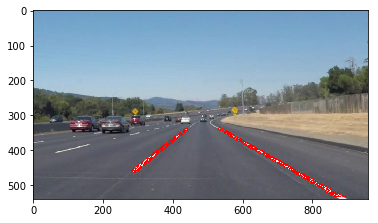

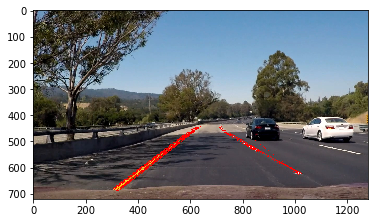

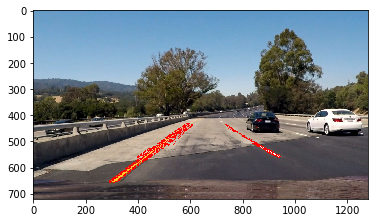

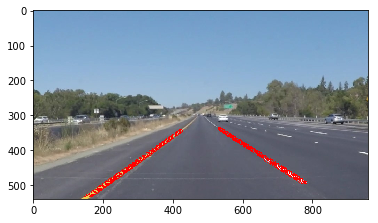

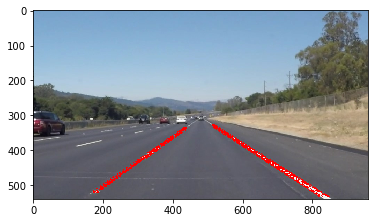

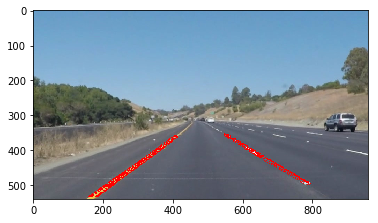

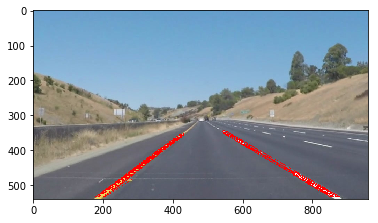

In [29]:
# 6.2 draw posible lines (set of lines) along the road lines
testImgscopy1= np.copy(testImgs)

for i in range(len(testImgs)):
    testImgscopy1[i] = draw_lines(np.copy(testImgs[i]),np.copy(possibleLines[i]) , color=[255, 0, 0], thickness=1)
    plt.imshow(testImgscopy1[i])
    plt.show()
    
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

## Defining Pipeline

Now, a summary function **process_image** is defined, so that **it returns** the processed image.

In [30]:


# import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

# realative paths

# path incoming information
pathInImgs = ('./test_images/')  # path incoming images
pathInVids = ('./test_videos/')  # path incoming videos

# path outgoing information
pathOutImgs = ('./test_images_output/')  # path incoming images
pathOutVids = ('./test_videos_output/')  # path incoming videos

namesTestImgs = os.listdir('./test_images/')
# list with all test images
initialTestImgs= []
for i in range(len(namesTestImgs)):
    initialTestImgs.append(mpimg.imread(pathInImgs+namesTestImgs[i]))
    
# create copy for initial images
testImgs = np.copy(initialTestImgs)
testImgscopy1= np.copy(testImgs)

#for i in testImgs:
#    plt.imshow(i)
#    plt.show()
    


def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    img= np.copy(image)
    imgx= np.copy(image)
    
    hlsImg = np.zeros_like(img)
    grayImg= np.zeros_like(img)
    blurImg= np.zeros_like(img)
    edgeImg= np.zeros_like(img)
    edgeclosedImg= np.zeros_like(img)
    regionImg= np.zeros_like(img)
    posslinesImg= np.zeros_like(img)
    possibleLines= np.zeros_like(img)
    
    
    hlsImg = hls_wyMask(np.copy(img))
    grayImg= grayscale(np.copy(hlsImg))
    blurImg= gaussian_blur(np.copy(grayImg), 11)
    edgeImg= canny(np.copy(blurImg), 50, 150)
    edgeclosedImg= closing_regions( np.copy(edgeImg), kernel= np.ones((3,3),np.uint8) )
    
    vertices = generate_vertices(np.copy(edgeclosedImg))
    regionImg= region_of_interest( np.copy(edgeclosedImg), vertices)
    
    xpoints,xlines = hough_lines( np.copy(regionImg), rho=1, theta= 1*np.pi/180, threshold=25, min_line_len= 35, max_line_gap= 180)
    posslinesImg= xpoints
    possibleLines= xlines
    
    imgx= draw_lines(imgx, possibleLines, color=[255, 0, 0], thickness=1)
    
    result = imgx
    #plt.imshow(result)
    #plt.show()
    
    return result


    
    

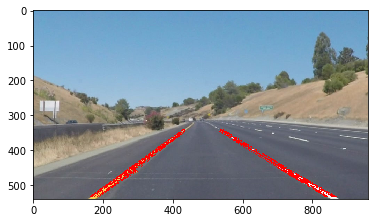

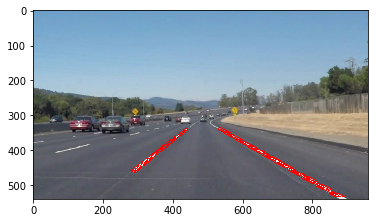

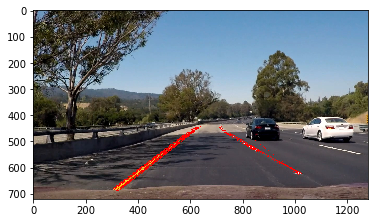

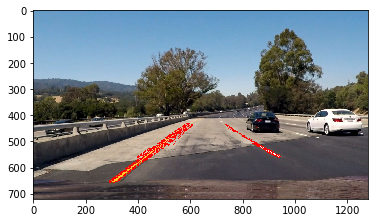

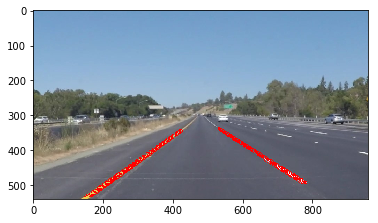

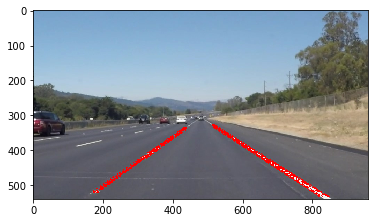

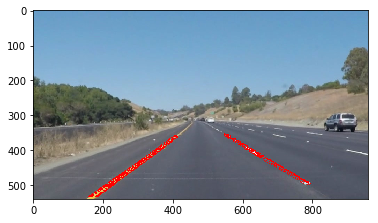

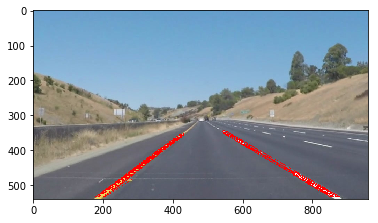

In [31]:
# Showing possible lines for the lines on the road
for i in range(len(testImgs)):
    plt.imshow(process_image(testImgs[i]))
    plt.show()
    
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

In [32]:
# Getting possible lines for the lines on the road for video1
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/red_lines_solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/red_lines_solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/red_lines_solidWhiteRight.mp4


 99%|█████████▉| 125/126 [00:09<00:00, 11.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/red_lines_solidWhiteRight.mp4 



In [33]:
# Getting possible lines for the lines on the road for video2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

yellow_output = 'test_videos_output/red_lines_solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/red_lines_solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/red_lines_solidYellowLeft.mp4


 99%|█████████▉| 125/126 [00:09<00:00, 12.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/red_lines_solidYellowLeft.mp4 



In [34]:
# Getting possible lines for the lines on the road for video2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

challenge_output = 'test_videos_output/red_lines_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/red_lines_challenge.mp4
[MoviePy] Writing video test_videos_output/red_lines_challenge.mp4


 99%|█████████▉| 125/126 [00:16<00:00,  4.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/red_lines_challenge.mp4 



## connect/average/extrapolate output lines

On this subsection, output _predicted road lines_ are averaged out so than _a single representative line_ as output lane line is shown, one for the left side and one for the right side.

So, function **draw_lines** used in the hough transformation step is now modified as follows:

In [44]:
def draw_lines2(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imgx = np.copy(img)
    
    mList= []
    bList= []
    l2NormList= []
    
    leftLines = []
    leftWeights = []
    rightLines = []
    rightWeights = []
    zeroLines = []
    zeroWeights= []
    
    ipsylum = 0.1
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(imgx, (x1, y1), (x2, y2), color, thickness)
            
            m= ((y2-y1)/(x2-x1))
            b= y2 -m*x2
            l2Norm= np.sqrt( ((y2-y1)**2) + ((x2-x1)**2))
            mList.append(m)
            bList.append(b)
            l2NormList.append(l2Norm)
            
            if m > ipsylum:
                leftLines.append(np.array([m,b], dtype=np.float32))
                leftWeights.append(l2Norm)
            elif m < -ipsylum:
                rightLines.append(np.array([m,b], dtype=np.float32))
                rightWeights.append(l2Norm)
            else:
                zeroLines.append(np.array([m,b], dtype=np.float32))
                
            
            if len(leftWeights)>0:
                #lineLeftt= np.average(np.asarray(leftLines), axis=0)
                lineLeftt= np.dot(leftWeights, leftLines)/(np.sum(leftWeights))
            #else:
            #    None
                
            if len(rightWeights)>0:
                #lineRigthh= np.average(np.asarray(rightLines), axis=0)
                lineRigthh = np.dot(rightWeights, rightLines)/(np.sum(rightWeights))
            #else:
            #    None
                
    #if len(leftWeights) = 0:
    #    lineLeftt
                 
            
    return mList, bList, l2NormList, leftLines, rightLines, zeroLines,leftWeights, rightWeights, lineLeftt, lineRigthh

Here two variables are the important ones (**lineL, lineR**). The other variables where used to debug possible np.Nan returned values or empty list values.

Resuming image processing since **hough transform**

In [45]:
# 6.1 compute hough transform
posslinesImgs= []
possibleLines= []
for i in range(len(testImgs)):
    xpoints,xlines = hough_lines(np.copy(regionImgs[i]), rho=1, theta= 1*np.pi/180, threshold=25, min_line_len= 30, max_line_gap= 180)
    
    posslinesImgs.append(xpoints)
    possibleLines.append(xlines)
    #plt.imshow(posslinesImgs[i])
    #plt.show()

# 7.1. get averaged (slope, b) for each line (Note: just lineL  and lineR are the important variables, the other ones are just for debugging purposes)
mlist= []
blist= []
l2normlist= []
linesL= []
linesR= []
zeroL= []
weightsL= []
weightsR= []
lineL= []
lineR= []

for i in range(len(testImgs)):
    [mlistx, blistx, l2normlistx, linesLx, linesRx, zeroLx, weightsLx, weightsRx, lineLx, lineRx]=draw_lines2(np.copy(testImgs[i]), possibleLines[i], color=[255, 0, 0], thickness=2)
    lineL.append(lineLx)
    lineR.append(lineRx)



#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

### Get image pixels for averaged lines

Here:
* Aproximated _left_ and _rigth_ linear functions are maped-back to the image space. 
* A helper function to return _averaged left-rigth lines_ as an array is defined.
* The provided helper function *weigthed_img* is used to aply trasnsparency to the predicted lines.
* Finally, predicted lines are painted over a copy of the original image.

In [46]:
# 7.1 get image pixels for averaged lines

def aproximated_lr_lines(img, avgLine, λ):
    m = avgLine[0]
    b = avgLine[1]
    
    y2 = img.shape[0]
    y1 = λ*y2
    
    x2 = (y2 -b)/m
    x1 = (y1 -b)/m
    
    return int(x1), int(y1), int(x2), int(y2)

In [47]:
# 7.2 get left and rigth lines in format ready to be introduced to draw_lines3

def avgLines_as_array(img, lineL, lineR):
    img2= np.zeros_like(img)
    lines2 = np.zeros((2,1,4),dtype= np.int32)
    
    lines2[0][0] =  np.asarray( aproximated_lr_lines(img2, lineL, 0.6), dtype= np.int32 )
    lines2[1][0] =  np.asarray( aproximated_lr_lines(img2, lineR, 0.6), dtype= np.int32 )

    return lines2

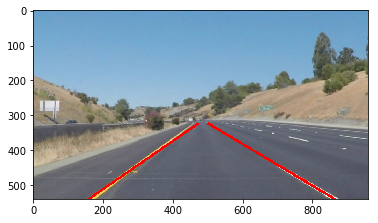

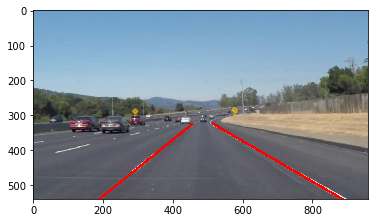

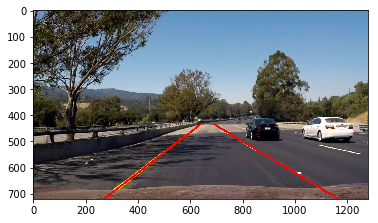

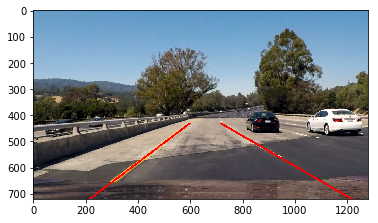

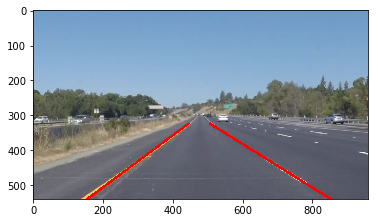

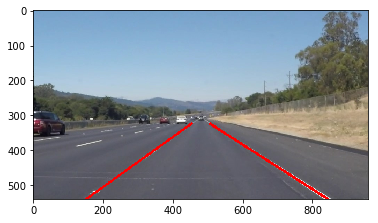

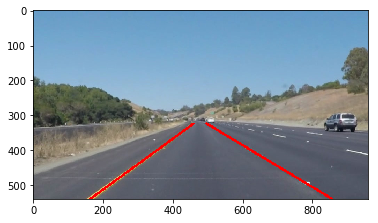

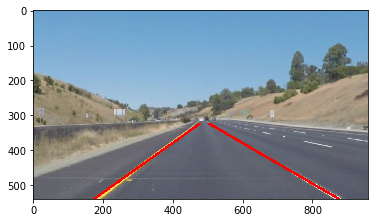

In [48]:
# 7.2 get left and rigth lines averaged aproximations


regionImgs3 = np.copy(regionImgs)
testImgscopy3 = np.copy(testImgs)

lines3= []
for i in range(len(testImgs)):
    lines3.append( avgLines_as_array(np.copy(regionImgs3[i]), lineL= lineL[i], lineR= lineR[i])  )
    testImgscopy3[i] = draw_lines(np.copy(testImgscopy3[i]), lines3[i], color=[255, 0, 0], thickness=5)
    plt.imshow(testImgscopy3[i])
    plt.show()
    
    
#for i in range(len(testImgs)):
#   plt.imshow(testImgs[i])
#   plt.show()

In [49]:
# 8. include the option to get weighted images = trasparency in lines

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [50]:
# 9. predicted lines painted over original image

def lines_on_image(initial_img, linesx,alpha=0.7, betha=0.5, color=[255, 0, 0], thickness=18):
    imx = np.zeros_like(initial_img)
    
    imx = draw_lines(np.copy(imx), linesx, color=color, thickness=thickness)
    dst = weighted_img(imx, initial_img, α= alpha, β= betha, λ=0.0)
    
    return dst

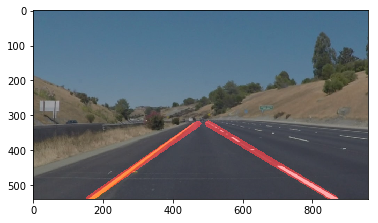

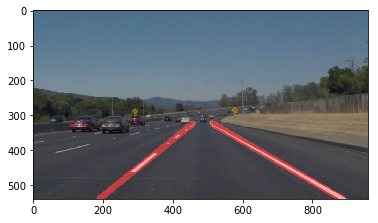

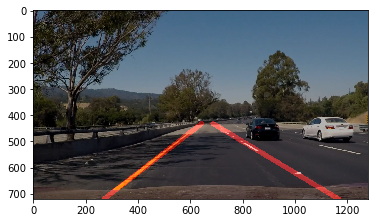

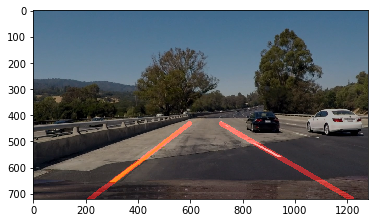

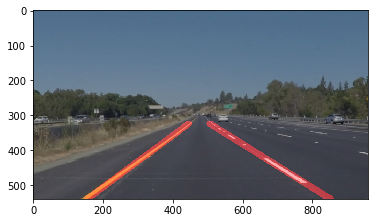

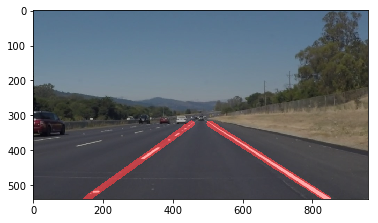

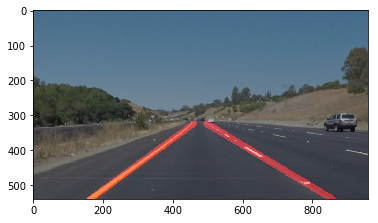

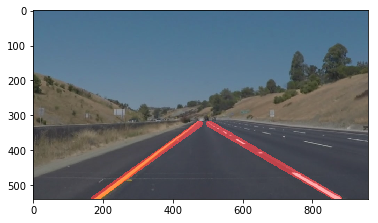

In [51]:
# 9. predicted lines painted over original image
for i in range(len(testImgs)):
    dst = lines_on_image(np.copy(testImgs)[i], lines3[i], alpha=0.7, betha=0.5, color=[255, 0, 0], thickness=18)
    plt.imshow(dst)
    plt.show()

#for i in range(len(testImgs)):
#   plt.imshow(testImgs[i])
#   plt.show()

**Note:** As you can see on the previous images, predicted lines are little deviated from the real road lines, so perturbations/wavy/noisy predicted lines are expected.

### Pipeline for averaged lines

Now, a summary function **process_image2** is defined, so that **it returns** the processed image for the averaged lines.

In [52]:


# import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

# realative paths

# path incoming information
pathInImgs = ('./test_images/')  # path incoming images
pathInVids = ('./test_videos/')  # path incoming videos

# path outgoing information
pathOutImgs = ('./test_images_output/')  # path incoming images
pathOutVids = ('./test_videos_output/')  # path incoming videos

namesTestImgs = os.listdir('./test_images/')
# list with all test images
initialTestImgs= []
for i in range(len(namesTestImgs)):
    initialTestImgs.append(mpimg.imread(pathInImgs+namesTestImgs[i]))
    
# create copy for initial images
testImgs = np.copy(initialTestImgs)
testImgscopy1= np.copy(testImgs)

#for i in testImgs:
#    plt.imshow(i)
#    plt.show()
    


def process_image2(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    img= np.copy(image)
    imgx= np.copy(image)
    
    hlsImg = np.zeros_like(img)
    grayImg= np.zeros_like(img)
    blurImg= np.zeros_like(img)
    edgeImg= np.zeros_like(img)
    edgeclosedImg= np.zeros_like(img)
    regionImg= np.zeros_like(img)
    posslinesImg= np.zeros_like(img)
    possibleLines= np.zeros_like(img)
    
    
    hlsImg = hls_wyMask(np.copy(img))
    grayImg= grayscale(np.copy(hlsImg))
    blurImg= gaussian_blur(np.copy(grayImg), 11)
    edgeImg= canny(np.copy(blurImg), 50, 150)
    edgeclosedImg= closing_regions( np.copy(edgeImg), kernel= np.ones((3,3),np.uint8) )
    
    vertices = generate_vertices(np.copy(edgeclosedImg))
    regionImg= region_of_interest( np.copy(edgeclosedImg), vertices)
    
    xpoints,xlines = hough_lines( np.copy(regionImg), rho=1, theta= 1*np.pi/180, threshold=25, min_line_len= 35, max_line_gap= 180)
    posslinesImg= xpoints
    possibleLines= xlines
    [mlistx, blistx, l2normlistx, linesLx, linesRx, zeroLx, weightsLx, weightsRx, lineLx, lineRx]= draw_lines2(np.copy(imgx), possibleLines, color=[255, 0, 0], thickness=2)
    
    lines3= avgLines_as_array( np.copy(regionImg), lineL= lineLx, lineR= lineRx )
    
    #imgx= draw_lines(imgx, possibleLines, color=[255, 0, 0], thickness=1)
    dst= lines_on_image(np.copy(imgx), lines3, alpha=0.7, betha=0.5, color=[255, 0, 0], thickness=18)
    
    result = dst
    #plt.imshow(result)
    #plt.show()
    
    return result


    
    

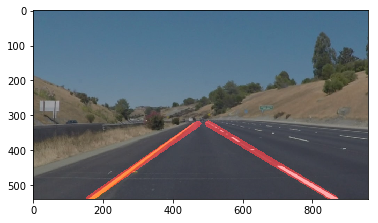

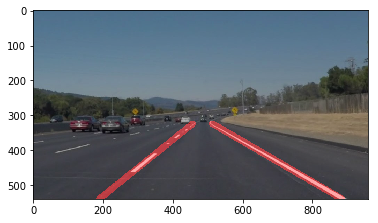

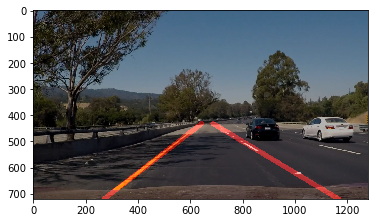

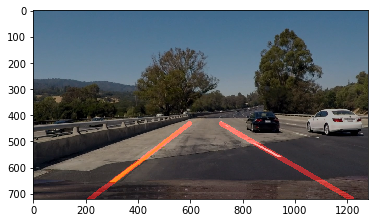

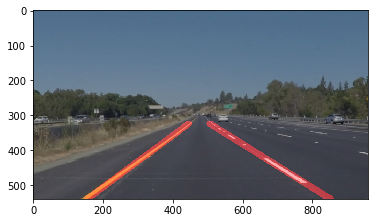

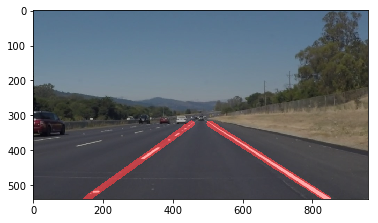

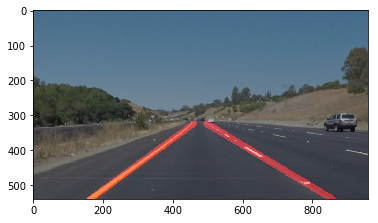

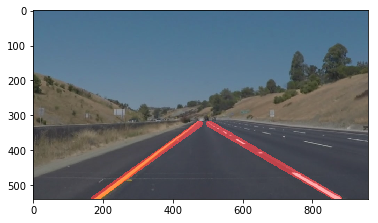

In [53]:
# Showing possible lines for the lines on the road

for i in range(len(testImgs)):
    plt.imshow(process_image2(testImgs[i]))
    plt.show()


#for i in range(len(testImgs)):
#    plt.imshow(process_image2(testImgs[i]))
#    plt.show()
    
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

In [79]:
# Getting possible lines for the lines on the road for video1
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/averaged_lines_solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image2) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/averaged_lines_solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/averaged_lines_solidWhiteRight.mp4


 99%|█████████▉| 125/126 [00:10<00:00,  9.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/averaged_lines_solidWhiteRight.mp4 



In [78]:
# Getting possible lines for the lines on the road for video2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

yellow_output = 'test_videos_output/averaged_lines_solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image2)
yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/averaged_lines_solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/averaged_lines_solidYellowLeft.mp4


 99%|█████████▉| 125/126 [00:09<00:00, 12.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/averaged_lines_solidYellowLeft.mp4 



In [77]:
# Getting possible lines for the lines on the road for video2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

challenge_output = 'test_videos_output/averaged_lines_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image2)
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/averaged_lines_challenge.mp4
[MoviePy] Writing video test_videos_output/averaged_lines_challenge.mp4


 99%|█████████▉| 125/126 [00:15<00:00,  6.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/averaged_lines_challenge.mp4 



### Conclusion

The project is successful in identifying lane lines properly. However is very clear that averaged lines are very oscilatory. So it can be smoothered by parameter tunning and extra image processing.

To improve:

* For images with high changes on light/bright, this project is slightly robust when using HLS masking, but when RGB masking is used instead, then the model is more sensitive to light abrupt changes, resulting in high variance predicted outputs.
* The average lines are sometimes deviated from the expected mean, and,  that is one of the reasons why predicted lines are wavy. Definitely this can be improved.
* Polygon (ROI) vertices selection should be implemented with an adaptative algoritm that recalibrates on hot, while vehicle is on the streets/roads. That is, because among all world streets/roads width and proportions may vary, so even if the model is calibrated for certain _roads_ it migh be uncalibrated for another _ones_.
